In [156]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob

import math

In [157]:
# Load the camera calibration matrix
K = np.load("calibration_matrix.npy")
distortion_coeffs = np.load("distCoeffs.npy")

print("calibration matrix is: \n" , K)
print("distortion_coeffs are: \n" , distortion_coeffs)


calibration matrix is: 
 [[2.30155415e+03 0.00000000e+00 1.13409396e+03]
 [0.00000000e+00 2.30321381e+03 1.52116518e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion_coeffs are: 
 [[ 1.76501798e-01 -6.62903260e-01 -5.19351920e-04  6.69463054e-04
   9.61475869e-01]]


In [158]:
# mat1 = []

# mat1.append([10,1,2])
# mat1.append([1,20,1])
# mat1.append([0,0,30])

# mat2 = np.array(mat1, dtype=np.float32)
# print("Test Rotation matrix is: \n", mat2)

# vec = np.float32([1,2,3])#.reshape(3,1)
# print("Test vector is: \n", vec)

# out = np.matmul(mat2,vec)

# print("matmul output is: \n", out)


Reading file: IMG_4722.jpg
Initial corners found


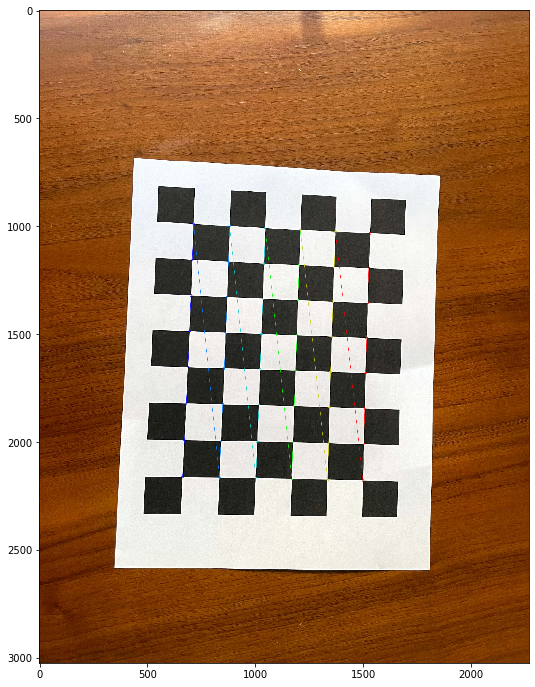

Homography for first image to top view shot is:
  [[ 5.75806197e-01  4.78956107e-02  5.38973898e+02]
 [-4.60918574e-02  6.27142727e-01  3.14717882e+02]
 [-2.34417627e-05  1.88224303e-05  1.00000000e+00]]
Image shape is:  (3024, 2268, 3)


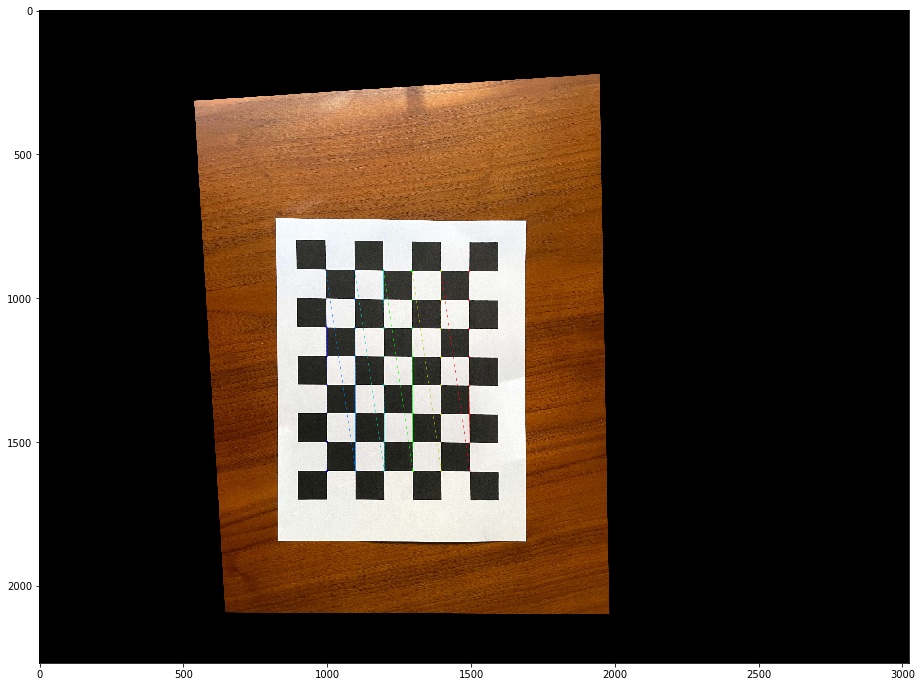

In [327]:
# Show a cube on the first image
#data = np.load('calibration_matrix.npy')
#Set the variables
folderpath = "images/calibrate_camera_images"
width = 8 # Width of checkerboard
height = 6 # Height of checkerboard pattern
square_size = 25 # Length of edge of square in meters 25mm
# flag_show_checkerboard_images = True


# Termination criteria for stopping subpixel corner calculation
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)


objpts = np.zeros((height*width,3), np.float32)
xx,yy = np.meshgrid(np.arange(0,width,1), np.arange(0,height,1))

# Reshape into 1d array
xx = xx.reshape(-1)
yy = yy.reshape(-1)

# Update coordinates of the XY points 
objpts[:,0] = xx
objpts[:,1] = yy    

# Sacle by the true size
objpts = square_size* objpts

fnames = os.listdir(folderpath)
# print(fnames)
for curr_file in fnames:
        if not '.jpg' in curr_file:
            continue
        
        print("Reading file: "+ curr_file )

        current_fname = os.path.join(folderpath,curr_file)
        img = cv2.imread(current_fname) # Read as grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Read as grayscale
        img_baseline = np.copy(img)
#         plt.imshow(img)
#         plt.show()
#         break
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        #Find the chessboard corners
        ret,corners = cv2.findChessboardCorners(gray,(width,height),
                                               cv2.CALIB_CB_ADAPTIVE_THRESH 
                                                + cv2.CALIB_CB_FAST_CHECK 
                                                + cv2.CALIB_CB_NORMALIZE_IMAGE)

        #If the corners are detected, run subpixel accuracy
        if ret:

            print("Initial corners found")
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
#             print(corners2)

            # Draw the corners
            img = cv2.drawChessboardCorners(img,(width,height),corners2,ret)

            figure(figsize=(16,12))
            plt.imshow(img,cmap='gray')
            plt.show()
            
            # Get Homography for first square to 
            src_pts = []
            src_pts.append(corners[0])
            src_pts.append(corners[1])
            src_pts.append(corners[9])
            src_pts.append(corners[8])
            src_pts = np.array(src_pts)
            src_pts = src_pts.reshape(-1,1,2)
            
            xx = 1000
            yy = 1500
            pt1 = [xx,yy+100]
            pt2 = [xx,yy]
            pt3 = [xx+100,yy]
            pt4 = [xx+100,yy+100]
            dst_pts = np.float32([pt1,pt2,pt3,pt4]).reshape(-1,1,2)

            
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#             M2, mask = cv2.findHomography(dst, src_pts, cv2.RANSAC,5.0)
            print("Homography for first image to top view shot is:\n ", M)
            matchesMask = mask.ravel().tolist()
            print("Image shape is: ", img.shape)
            h,w,d = img.shape
            
#             pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.warpPerspective(img,M,(h,w))
            
            figure(figsize=(16,12))
            plt.imshow(dst)
            plt.show()

        break
        

In [167]:
#Homography from flat to tilted
H, mask2 = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
print("Computed Homography = \n", H)


Computed Homography = 
 [[ 1.70983848e+00 -1.03905055e-01 -8.88857531e+02]
 [ 1.06556994e-01  1.61961980e+00 -5.67154750e+02]
 [ 3.80759663e-05 -3.29208983e-05  1.00000000e+00]]


In [370]:
def compute_projection_matrix(H,K):
    # H = K * [c1|c2|t]
    # Kinv * H = [c1|c2|t]
#     H = -1*H
    print("K is= \n ",K)
    print("H is= \n ",H)

    M = np.linalg.inv(K)
    print("Kinv is= \n ",M)
    
    M = np.matmul(M,H)
    print("Kinnv * H = \n", M)
    
    # Get the first 2 columns
    a = M[:,0]
    b = M[:,1]
    t  = M[:,2]
    
    l = math.sqrt(np.linalg.norm(a) * np.linalg.norm(b))

    
    #Normalize the columns:
    a = a /l# np.linalg.norm(a) 
    b = b /l# np.linalg.norm(b)
    t = t/l
    

    print("a:", a)
    print("b:", b)
    print("t \n before normalization: {}, \n after normallization: {}".format(M[:,2], t))
    print("l:", l)
    
    c = np.cross(a,b)
    c = c / np.linalg.norm(c)
    
#     # Get summed vector
#     c = a+b 
#     c = c / np.linalg.norm(c)
    
#     d = np.cross(a,b)
#     d = d/np.linalg.norm(d)
    
#     e = np.cross(c,d)
#     e = e/np.linalg.norm(e)
    
    
#     print(c,d,e)
#     r1 = c+d
#     r1 = r1/np.linalg.norm(r1)
    
#     r2 = c-d
#     r2 = r2/np.linalg.norm(r2)
#     r3 = np.cross(r1,r2)

    c1 = a
    c2 = b
    c3 = c
    
    
    print("Normalized columns : ", c1,c2,c3)
    
    # Make the Extrinsic matrix
    ext_mat = np.stack((c1,c2,c3,t),axis=1)
    print("Ext matrix is: \n", ext_mat)
    
    # Get projection matrix
    proj_matrix = np.matmul(K,ext_mat)
    print("proj_matrix is: \n", proj_matrix)
    
    return proj_matrix

In [371]:
proj_matrix = compute_projection_matrix(H,K)

K is= 
  [[2.30155415e+03 0.00000000e+00 1.13409396e+03]
 [0.00000000e+00 2.30321381e+03 1.52116518e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
H is= 
  [[ 1.70983848e+00 -1.03905055e-01 -8.88857531e+02]
 [ 1.06556994e-01  1.61961980e+00 -5.67154750e+02]
 [ 3.80759663e-05 -3.29208983e-05  1.00000000e+00]]
Kinv is= 
  [[ 4.34489018e-04  0.00000000e+00 -4.92751370e-01]
 [ 0.00000000e+00  4.34175932e-04 -6.60453310e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Kinnv * H = 
 [[ 7.24144056e-04 -2.89237873e-05 -8.78950206e-01]
 [ 2.11170842e-05  7.24942650e-04 -9.06698252e-01]
 [ 3.80759663e-05 -3.29208983e-05  1.00000000e+00]]
a: [0.99763769 0.02909255 0.05245644]
b: [-0.03984768  0.9987379  -0.04535441]
t 
 before normalization: [-0.87895021 -0.90669825  1.        ], 
 after normallization: [-1210.91079249 -1249.13867822  1377.67848984]
l: 0.0007258587597743917
Normalized columns :  [0.99763769 0.02909255 0.05245644] [-0.03984768  0.9987379  -0.04535441] [-0.0537143   

In [374]:
# Noow that I have the projection matrix, project a cube into image space

print("Homography H = \n ", H)
print("\n Projection Matrix:  = \n ", proj_matrix)

ptsA = np.array([ 
    objpts[0],
    objpts[1],
    objpts[9],
    objpts[8]]
)

# print(objpts[1])
# print(K)

# a = np.matmul(proj_matrix,np.array(objpts[8],1))

# a = a/a[2]
# print(a)

# dst = cv2.perspectiveTransform(ptsA.reshape(-1, 1, 3), proj_matrix)
# print(type(dst_pts))

out = []
for pt in dst_pts:
    out.append(np.append(pt,[0,1]))

pts_3d  = np.array(out)


pts_v2 = np.copy(pts_3d)
pts_v2[:,2] = 300
pts_3d = np.append(pts_3d,pts_v2,axis=0)

print(pts_3d.shape)
print("\n pts_3d Homogeneous coordinates are: \n",  pts_3d)

# dst = cv2.perspectiveTransform(ptsA.reshape(-1, 1, 3), proj_matrix)
# dst = cv2.perspectiveTransform(pts_3d.reshape(-1, 1, 3), proj_matrix)
dst = np.matmul(proj_matrix,pts_3d.T).T

out = []
for pt in dst:
    out.append(pt/pt[2])
    
dst = np.array(out)    
print(type(dst))

# print(dst_pts[0].shape)
# print("Initial points: \n ", pts_3d)
print("\n Transformed points:\n ",  dst)

# asd = np.matmul(H,np.array([1000,1600,1]))
# asd /= asd[2]
# print("\n Transformed point using homographys:\n ",  asd)

print("\n Original src points: \n" , src_pts)

# print(proj_matrix[:,3]/1.3776e3)

# dst[:,:2]


Homography H = 
  [[ 1.70983848e+00 -1.03905055e-01 -8.88857531e+02]
 [ 1.06556994e-01  1.61961980e+00 -5.67154750e+02]
 [ 3.80759663e-05 -3.29208983e-05  1.00000000e+00]]

 Projection Matrix:  = 
  [[ 2.35560769e+03 -1.43147759e+02  1.00777200e+03 -1.22455990e+06]
 [ 1.46801278e+02  2.23131535e+03  1.61695789e+03 -7.81356900e+05]
 [ 5.24564398e-02 -4.53544134e-02  9.97623139e-01  1.37767849e+03]]
(8, 4)

 pts_3d Homogeneous coordinates are: 
 [[1.0e+03 1.6e+03 0.0e+00 1.0e+00]
 [1.0e+03 1.5e+03 0.0e+00 1.0e+00]
 [1.1e+03 1.5e+03 0.0e+00 1.0e+00]
 [1.1e+03 1.6e+03 0.0e+00 1.0e+00]
 [1.0e+03 1.6e+03 3.0e+02 1.0e+00]
 [1.0e+03 1.5e+03 3.0e+02 1.0e+00]
 [1.1e+03 1.5e+03 3.0e+02 1.0e+00]
 [1.1e+03 1.6e+03 3.0e+02 1.0e+00]]
<class 'numpy.ndarray'>

 Transformed points:
  [[6.64431885e+02 2.16235889e+03 1.00000000e+00]
 [6.72728821e+02 1.99134485e+03 1.00000000e+00]
 [8.42423523e+02 1.99444153e+03 1.00000000e+00]
 [8.34723267e+02 2.16480762e+03 1.00000000e+00]
 [7.26885042e+02 2.06453595e+03

0
[ 664 2162] [ 726 2064]
1
[ 672 1991] [ 733 1924]
2
[ 842 1994] [ 872 1927]
3
[ 834 2164] [ 866 2066]
4


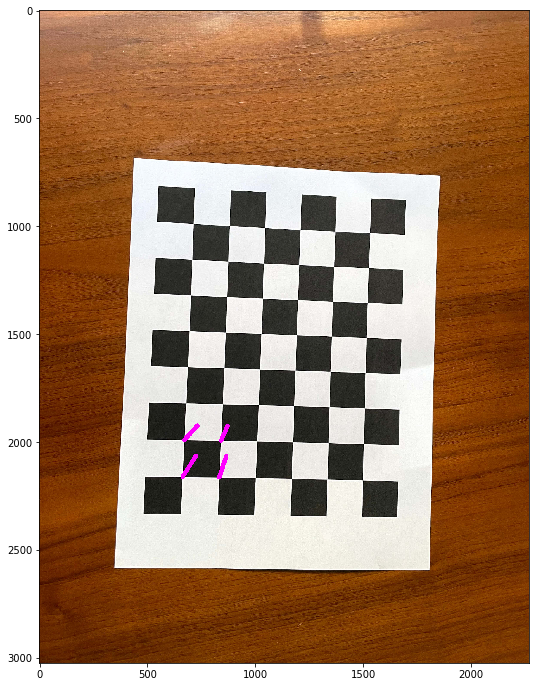

In [375]:
# Overlay the points
img2 = np.copy(img_baseline)
figure(figsize=(16,12))
# plt.imshow(img2)
# plt.show()

# cv2.polylines(img2,dst[:,:2])

isClosed = False

# Blue color in BGR
color = (255, 0, 255)
  
# Line thickness of 2 px
thickness = 20

for i in range(dst.shape[0]):
    print(i)

    if(i>=dst.shape[0]//2):
        break

    pt1 = np.int32(dst[i,:2])
    pt2 = np.int32(dst[i+4,:2])
    
    print(pt1,pt2)
# # Using cv2.polylines() method
# # Draw a Blue polygon with 
# # thickness of 1 px
    img2 = cv2.polylines(img2, [np.array([pt1,pt2]).reshape(-1,1,2)], 
                          isClosed, color, thickness)

plt.imshow(img2)
plt.show()

In [376]:
#Decompose this homography matrix
retval, rotations, translations, normals = cv2.decomposeHomographyMat(H,K)

# print(retval)
print("Rotations")
for rot in rotations:
    print(rot)
print("Translations")
for tv in translations:
    print(tv)
# print(translations)
print("Normals")
for nor in normals:
    print(nor)


Rotations
[[ 0.9924495  -0.01597693 -0.12160889]
 [ 0.03935629  0.98053408  0.19236423]
 [ 0.11616827 -0.19569786  0.97375935]]
[[ 0.9924495  -0.01597693 -0.12160889]
 [ 0.03935629  0.98053408  0.19236423]
 [ 0.11616827 -0.19569786  0.97375935]]
[[ 0.99908997 -0.03794993 -0.01946856]
 [ 0.03842047  0.99896389  0.02439292]
 [ 0.01852268 -0.02511872  0.99951286]]
[[ 0.99908997 -0.03794993 -0.01946856]
 [ 0.03842047  0.99896389  0.02439292]
 [ 0.01852268 -0.02511872  0.99951286]]
Translations
[[-0.06584847]
 [ 0.06539435]
 [ 0.41008409]]
[[ 0.06584847]
 [-0.06539435]
 [-0.41008409]]
[[ 0.04191771]
 [-0.1084903 ]
 [ 0.40404722]]
[[-0.04191771]
 [ 0.1084903 ]
 [-0.40404722]]
Normals
[[-0.15472176]
 [ 0.3659817 ]
 [-0.91767019]]
[[ 0.15472176]
 [-0.3659817 ]
 [ 0.91767019]]
[[ 0.08463531]
 [-0.05072644]
 [-0.99511994]]
[[-0.08463531]
 [ 0.05072644]
 [ 0.99511994]]
